In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [53]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

... ---> e
..e ---> l
.el ---> i
eli ---> a
lia ---> n
ian ---> y
any ---> s
nys ---> .
... ---> t
..t ---> r
.tr ---> o
tro ---> y
roy ---> .
... ---> m
..m ---> a
.ma ---> r
mar ---> k
ark ---> u
rku ---> s
kus ---> .
... ---> r
..r ---> a
.ra ---> w
raw ---> d
awd ---> a
wda ---> h
dah ---> .
... ---> a
..a ---> m
.am ---> i
ami ---> e
mie ---> .


In [54]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [55]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words[:5]:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([33, 3]) torch.Size([33])
torch.Size([34, 3]) torch.Size([34])
torch.Size([35, 3]) torch.Size([35])


In [56]:
C = torch.randn((27, 2))

In [57]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [58]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [59]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [60]:
h

tensor([[ 0.2902, -0.9720, -0.5531,  ...,  0.0327, -0.9782, -0.8866],
        [-0.9050, -0.9981, -0.9936,  ..., -0.9800, -0.9755, -0.6882],
        [-0.9753, -0.9685,  0.0982,  ..., -0.8275, -0.9841,  0.8355],
        ...,
        [-0.6556, -0.9988, -0.9859,  ..., -0.9879, -0.9499, -0.9709],
        [-0.9946,  0.3311,  0.5590,  ..., -0.9978, -0.9953,  0.9910],
        [-0.6691, -0.5117, -0.9712,  ..., -0.1674, -0.9371,  0.7716]])

In [61]:
h.shape

torch.Size([32, 100])

In [62]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [63]:
logits = h @ W2 + b2

In [64]:
logits.shape

torch.Size([32, 27])

In [65]:
counts = logits.exp()

In [66]:
prob = counts / counts.sum(1, keepdims=True)

In [67]:
prob

tensor([[1.0125e-04, 5.5503e-07, 2.4744e-15, 5.4563e-11, 1.5183e-06, 4.0289e-11,
         2.1993e-04, 3.6024e-08, 2.0926e-07, 2.3814e-01, 1.7406e-06, 1.2138e-05,
         1.9238e-08, 5.5049e-13, 1.2049e-08, 6.3066e-07, 1.2834e-09, 5.6748e-09,
         2.3730e-05, 2.1352e-06, 2.2262e-10, 7.6150e-01, 4.8911e-10, 1.2701e-06,
         9.1303e-07, 1.3803e-12, 1.6089e-06],
        [9.9962e-01, 9.2160e-09, 5.6681e-11, 2.8290e-11, 4.2929e-16, 5.6019e-12,
         1.5262e-05, 9.9265e-13, 1.3172e-08, 1.4167e-04, 4.1643e-10, 1.2151e-10,
         3.0161e-11, 5.1061e-18, 2.1751e-14, 4.9580e-16, 5.8443e-15, 8.7099e-08,
         2.1951e-04, 1.4600e-13, 4.6790e-12, 1.5099e-06, 2.8316e-12, 1.4049e-09,
         7.6907e-12, 1.5374e-10, 4.5160e-11],
        [9.0228e-20, 7.3728e-11, 9.6256e-18, 7.8603e-15, 8.1687e-13, 3.5074e-13,
         1.1304e-07, 4.3164e-09, 4.6224e-09, 9.9989e-01, 6.8173e-15, 7.1810e-10,
         2.6657e-09, 6.7486e-16, 1.8939e-13, 3.2612e-10, 3.2851e-12, 3.5951e-12,
         1.1302e-

In [68]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.4348)

In [ ]:
# ------------ now made respectable :) ---------------

In [69]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([33, 3]), torch.Size([33]))

In [70]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [71]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [72]:
for p in parameters:
  p.requires_grad = True

In [74]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [75]:
lri = []
lossi = []
stepi = []

In [86]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

0.32050907611846924
0.27773842215538025
0.5336047410964966
0.3690875768661499
0.33247244358062744
0.16192205250263214
0.19008228182792664
0.25028061866760254
0.2733779847621918
0.17256580293178558
0.26441824436187744
0.5543997287750244
0.46716687083244324
0.17236332595348358
0.23205070197582245
0.03242778778076172
0.13514599204063416
0.0919794887304306
0.536065399646759
0.13089188933372498
0.2505928874015808
0.20150312781333923
0.10599406808614731
0.3548203706741333
0.24038653075695038
0.40613871812820435
0.2113463431596756
0.29723209142684937
0.19759394228458405
0.36534643173217773
0.3933356702327728
0.22526155412197113
0.2331336885690689
0.3661258816719055
0.42916977405548096
0.2518399655818939
0.036622025072574615
0.26848304271698
0.25253233313560486
0.31083106994628906
0.313111275434494
0.33900755643844604
0.375988632440567
0.4057445228099823
0.4555545151233673
0.8127056360244751
0.31989586353302
0.3341299891471863
0.4465387761592865
0.1972661167383194
0.19903099536895752
0.1773976

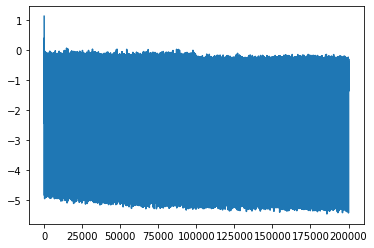

In [87]:
plt.plot(stepi, lossi)

In [88]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(0.2469, grad_fn=<NllLossBackward0>)

In [89]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(19.2774, grad_fn=<NllLossBackward0>)

RuntimeError: Numpy is not available

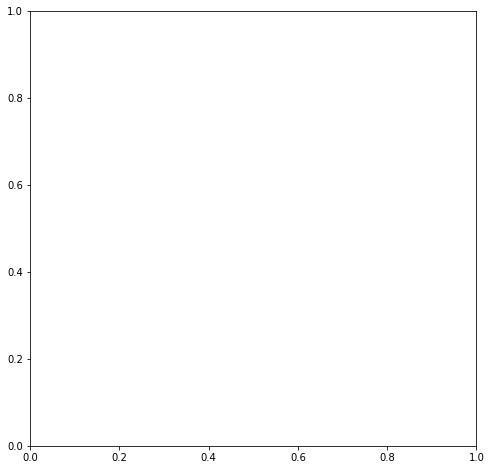

In [95]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [91]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [92]:


# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

coalson.
bryer.
shaindy.
bryer.
shaindy.
bryer.
nyree.
nyree.
edie.
edie.
shaindy.
bryer.
nyree.
shaindy.
bryer.
nyree.
nyree.
nyree.
coalson.
bryer.
